**Paper study developed by Henry Chacon as part of the survey review of Backdoor attacks including on my dissertation at UTSA.**

Contact information: henry.chacon@utsa.edu, henrychacon@gmail.com

# *Paper title:* Universal adversarial perturbations

Authors: Moosavi_Dezfooli et al. 
CVPR 2017. [Paper Link](https://openaccess.thecvf.com/content_cvpr_2017/html/Moosavi-Dezfooli_Universal_Adversarial_Perturbations_CVPR_2017_paper.html)

### Abstract

Given a state-of-the-art deep neural network classifier, we show the existence of a universal (image-agnostic) and very small perturbation vector that causes natural images to be misclassified with high probability. We propose a systematic algorithm for computing universal perturbations, and show that state-of-the-art deep neural networks are highly vulnerable to such perturbations, albeit being quasi-imperceptible to the human eye. We further empirically analyze these universal perturbations and show, in particular, that they generalize very well across neural networks. The surprising existence of universal perturbations reveals important geometric correlations among the high-dimensional decision boundary of classifiers. It further outlines potential security breaches with the existence of single directions in the input space that adversaries can possibly exploit to break a classifier on most natural images.

## Paper's main idea:
The authors suggested the existence of quasi-imperceptible perturbation vectors able to confuse an image classification model with high probability. The backdoor corresponds to the addition of a very small perturbation to all the inputs being easy to implement and difficult to be detected since perturbation is small and does not affect the input's distribution. The idea behind the methodology is to exploit insights on the input's categories topology by analyzing the dependency structure between different attributes of the decision boundary. Hence, the algorithm introduces a perturbation in the input that moves the image to the decision boundaries of the classifier. 

Most of the traditional backdoor attacks are focused on perturbing just one image at a time. However, it is limited for generalization of un-seen inputs, since prior data is required to produce the attack. This is an advantage of the universal adversarial patterns over classical backdoor attack methods. Because is not only applicable to un-seen inputs to be misclassifyied with a high probability, but also across different other models (model's Transferability).

## Universal perturbations:
Let's consider $\mu$ as the distribution of the input images $x \in \mathbb{R}^d$ and $\hat{k}: \mathbb{R}^d \to \mathbb{N}$ the image classifier. The model's idea is to create and input $v \in \mathbb{R}^d$ that fool the classifier $\hat{k}(x)$ in almost all the points such that:

$\hat{k}(x+v) \ne \hat{k}(x): \qquad x \sim \mu$

The vector's perturbation is limited in terms of an $\ell_p$ norm with $p \in [1, \infty)$ and constrained to:

1. $||v||_p \le \xi$
2. $\mathbb{P}_{x \sim \mu} \left(\hat(k)(x+v) \ne \hat{k}(x)   \right) \ge 1-\delta$ 

where $\xi$ is the maximum perturbation magnitude and $\delta$ the quantile fooling rate.

## Algorithm explanation:

<img src="UAP_algorithm.png" alt="drawing" width="400"/>

- The algorithm starts with an initial perturbation equal to zero $v=0$ (line 3)
- In line 4, the while loop condition $Err(X_v) \le 1- \delta$ is computed as follows:
$Err(X_v):= \frac{1}{m} \sum_{i=1}^m 1_{\hat{k}(x_i+v) \ne \hat{k}(x_i)} \ge 1-\delta$. It estimates the number of images in the sample $X=\lbrace x_1, \cdots, x_m  \rbrace$ that are misclassify by the vector $v$. If that average is larger than the quantile: $1-\delta$, the while loop is stopped.
- If the image is not misclasify in the comparison statement in line 6, the minimal perturbation $r$ to be added to the vector $v$ is computed by the equation:
$$\Delta v_i:= \arg min_r ||r||_2 \quad \text{s.t.} \quad  \hat{k}(x_i+v+r) \ne \hat{k}(x_i)$$ 
- Finally, the vector perturbation is updated in line 8 by the following equation. It ensures the perturbed vector is minimum and less than $\xi$.
$$\mathcal{P}_{p, \xi}(v) = \arg min_{v'} ||v - v'||_2 \quad \text{s.t.} \quad || v' || \le \xi   $$ 

## Code implementation:

The original code can be found in the [link](https://github.com/LTS4/universal/tree/master/python). It is developed on TensorFlow. However, an updated version of PyTorch 1.5.1 is presented here using a pre-trained VGG16 model from the PyTorch library.

In [11]:
import numpy as np
import random

import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import models

In [12]:
# check GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Downloading the data set:

In [13]:
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)
cifar_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

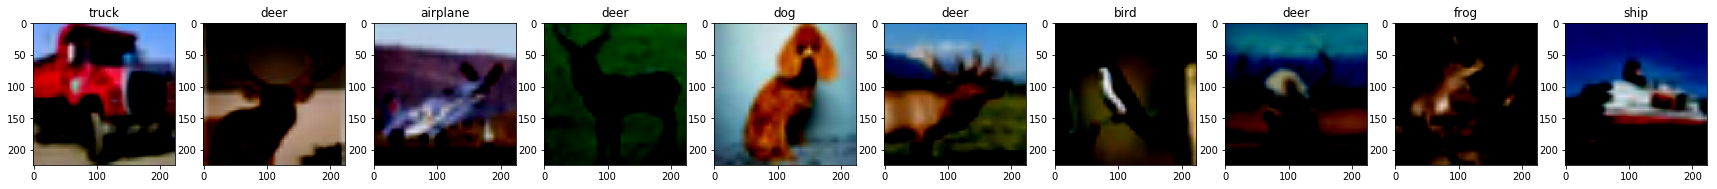

In [76]:
num_img = 10
fig = plt.figure(figsize=(30, 8))
for i, im_n in enumerate(random.sample(range(len(trainset)), num_img)):
    image = trainset[im_n][0].numpy()
    plt.subplot(1, num_img, i+1)
    sample_image = np.squeeze(np.transpose(image, (1, 2, 0)))
    plt.imshow(sample_image, cmap='gray' if (len(sample_image.shape)==2) else None)
    plt.title(cifar_labels[trainset[im_n][1]])

#### Downloading a pre-trained model parameters:

In [15]:
vgg16 = models.vgg16(pretrained=True)
vgg16.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [16]:
model_parameters = filter(lambda p: p.requires_grad, vgg16.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('Number of parameters in the model:', params)

Number of parameters in the model: 138357544


#### Changing the number of nodes (classes) in the output layer from 1000 to 10 and freezing convolution weights:

In [29]:
# vgg16.classifier[6].out_features = 10
vgg16.classifier[6] = nn.Linear(4096, 10)
vgg16.to(device)

# freeze convolution weights
for param in vgg16.features.parameters():
    param.requires_grad = False
    
print(vgg16)
model_parameters = filter(lambda p: p.requires_grad, vgg16.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('Number of parameters in the model:', params)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

#### Training the model's classifier layers:
_Go to the next section if you don't want to train the model from scratch and use trained parameters included in the root path_

In [32]:
# validation function
def validate(model, test_dataloader):
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    for int, data in enumerate(test_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        output = model(data)
        loss = criterion(output, target)
        
        val_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        val_running_correct += (preds == target).sum().item()
    
    val_loss = val_running_loss/len(test_dataloader.dataset)
    val_accuracy = 100. * val_running_correct/len(test_dataloader.dataset)
    print(f'Validation Loss: {val_loss:.4f}, Validation Acc: {val_accuracy:.2f}')
    
    return val_loss, val_accuracy

optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# training function
def fit(model, train_dataloader):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, data in enumerate(train_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
    train_loss = train_running_loss/len(train_dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}')
    
    return train_loss, train_accuracy

In [33]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()
for epoch in range(10):
    train_epoch_loss, train_epoch_accuracy = fit(vgg16, trainloader)
    val_epoch_loss, val_epoch_accuracy = validate(vgg16, testloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
end = time.time()
print((end-start)/60, 'minutes')

Train Loss: 0.0212, Train Acc: 75.98
Validation Loss: 0.0152, Validation Acc: 82.86
Train Loss: 0.0141, Train Acc: 84.31
Validation Loss: 0.0135, Validation Acc: 85.03
Train Loss: 0.0112, Train Acc: 87.42
Validation Loss: 0.0129, Validation Acc: 85.90
Train Loss: 0.0091, Train Acc: 89.76
Validation Loss: 0.0124, Validation Acc: 86.41
Train Loss: 0.0072, Train Acc: 91.98
Validation Loss: 0.0120, Validation Acc: 86.91
Train Loss: 0.0056, Train Acc: 93.79
Validation Loss: 0.0123, Validation Acc: 87.16
Train Loss: 0.0042, Train Acc: 95.53
Validation Loss: 0.0127, Validation Acc: 87.27
Train Loss: 0.0031, Train Acc: 96.65
Validation Loss: 0.0132, Validation Acc: 87.23
Train Loss: 0.0023, Train Acc: 97.71
Validation Loss: 0.0137, Validation Acc: 87.46
Train Loss: 0.0017, Train Acc: 98.34
Validation Loss: 0.0142, Validation Acc: 87.68
52.71083699862162 minutes


In [35]:
# Saving the trained model
torch.save(vgg16.state_dict(), 'vgg16-cifar.pt')

#### Download a pre-trained VGG-16 model

If you want to use a pre-trained model for VGG-10 with Train Loss: 0.0017, Train Acc: 98.34, Validation Loss: 0.0142, Validation Acc: 87.68, download the model's parameters: `vgg16-cifar_pre.pt` (located in the root folder path) and run the command:

In [ ]:
vgg16.load_state_dict(torch.load('vgg16-cifar_pre.pt'))

## Computing the Universal Adversarial Perturbation vector:

In [36]:
# freezing model parameters
for param in vgg16.features.parameters():
    param.requires_grad = False
    
for param in vgg16.avgpool.parameters():
    param.requires_grad = False
    
for param in vgg16.classifier.parameters():
    param.requires_grad = False

In [37]:
# Parameters definition:
xiv = 2000
sigma = 0.1

In [38]:
num_img = 1000

# Adversarial perturbation definition. Algorithm line 3
v = torch.zeros_like(trainset[0][0], device=device, requires_grad=False)

crossentropy=torch.nn.CrossEntropyLoss()

# Evaluation of the purturbation in all the point of the sample:

sample = random.sample(range(len(testset)), num_img)

err_xv, num_iter = 0, 0
while (err_xv < (1 - sigma)) and (num_iter < 20):
    for i in sample:
        data, target = torch.unsqueeze(testset[i][0], dim=0).to(device), torch.tensor(testset[i][1], dtype=torch.int).to(device)
        out = vgg16(data + torch.unsqueeze(v, dim=0))
        if torch.unsqueeze(target, dim=0) == torch.max(out, 1)[1]:    # Algorithm line 5
            r = torch.zeros_like(trainset[0][0], device=device, requires_grad=True)    # Algorithm line 3
            optimizerX = optim.SGD(params=[r],lr=1e+3)

            band, cnt = True, 0
            while(band):    # Algorithm line 7
                outp = vgg16(data + torch.unsqueeze(r, dim=0) + torch.unsqueeze(v, dim=0))
                loss =  torch.norm(r) +  1 - torch.abs(crossentropy(outp,  torch.max(out, 1)[1]))
                optimizerX.zero_grad()
                loss.backward()
                optimizerX.step()
                if (target != torch.max(outp, 1)[1]) or (cnt > 20):
                    band = False
                cnt += 1

            band, cnt = True, 0
            while(band):    # Algorithm line 7
                loss =  torch.norm(r) +  torch.norm(r) - xiv    # Algorithm line 8, assuming p = 2
                optimizerX.zero_grad()
                loss.backward()
                optimizerX.step()

                if (torch.norm(r) <= xiv) or (cnt > 20):
                    band = False
                cnt += 1

            # Updating the vector v with r
            v = r.data

#             print('Sample:', i , 'Vector norm:', torch.norm(r).data.cpu().numpy())

    # Computing stop condition define in Algorithm line 4

    counter = 0
    for i in sample:
        data, target = torch.unsqueeze(testset[i][0], dim=0).to(device), torch.tensor(testset[i][1], dtype=torch.int).to(device)
        out = vgg16(data + torch.unsqueeze(v, dim=0))
        if torch.unsqueeze(target, dim=0) != torch.max(out, 1)[1]:
#             print(torch.unsqueeze(target, dim=0),  torch.max(out, 1)[1])
            counter += 1

    err_xv = counter / len(sample)
    print('Misclassification error: {:.2f}'.format(err_xv))
    num_iter += 1
print('Process finished')

Misclassification error: 0.91


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


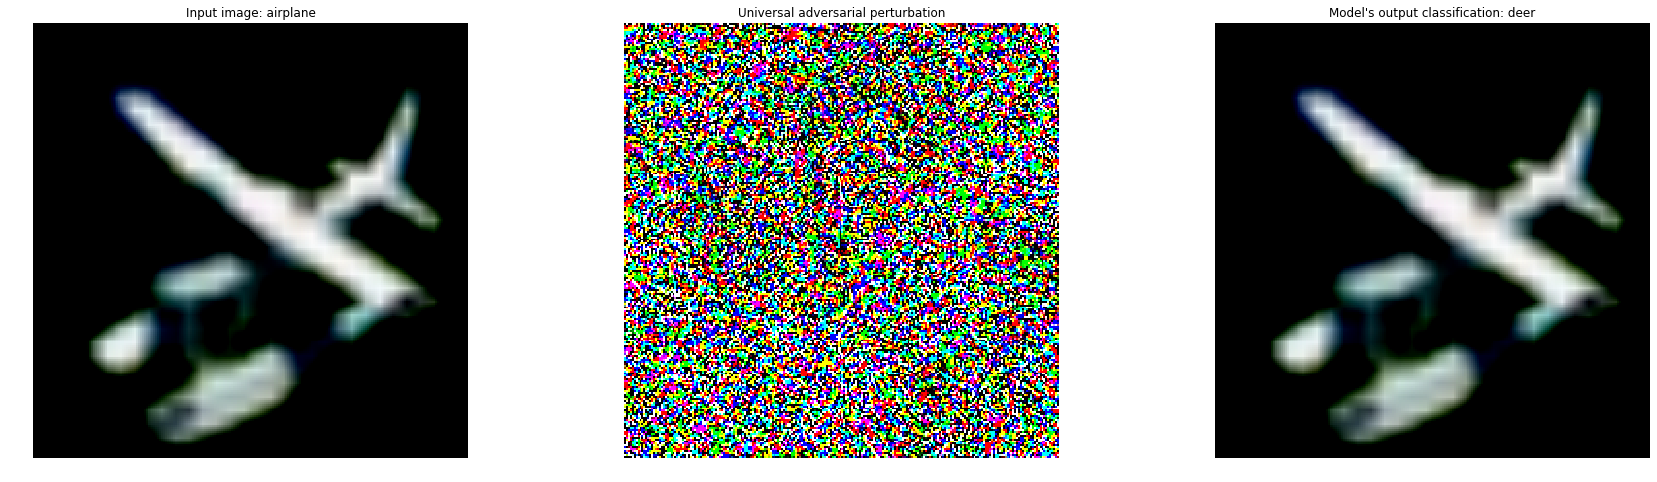

In [75]:
sample_num = 47

# Displaying the Universal Adversarial Perturbation
fig = plt.figure(figsize=(30, 8))

# Clean image
image = trainset[sample[sample_num]][0].numpy()
plt.subplot(1, 3, 1)
sample_image = np.squeeze(np.transpose(image, (1, 2, 0)))
plt.imshow(sample_image, cmap='gray' if (len(sample_image.shape)==2) else None)
plt.title('Input image: {}'.format(cifar_labels[trainset[sample[sample_num]][1]]))
plt.axis('off')

# Universal Perturbation
image = v.cpu().numpy()
plt.subplot(1, 3, 2)
sample_image = np.squeeze(np.transpose(image, (1, 2, 0)))
plt.imshow(sample_image, cmap='gray' if (len(sample_image.shape)==2) else None)
plt.title('Universal adversarial perturbation')
plt.axis('off')

# Attacked image
image = trainset[sample[sample_num]][0].numpy() + v.cpu().numpy()
plt.subplot(1, 3, 3)
sample_image = np.squeeze(np.transpose(trainset[sample[sample_num]][0].numpy(), (1, 2, 0)))
plt.imshow(sample_image, cmap='gray' if (len(sample_image.shape)==2) else None)
plt.title("Model's output classification: {}".format(cifar_labels[torch.max(vgg16(torch.unsqueeze(torch.tensor(image, device=device), dim=0)), 1)[1].cpu().numpy()[0]]))
plt.axis('off')

plt.savefig('universal_adversarial_perturbation.png')
